In [2]:
import sys
sys.path.append("../")
import os
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import math
from scipy.stats import ttest_rel, ks_2samp
import seaborn as sns 
from statannot import add_stat_annotation

from coh_tools import *

In [7]:
repo_dir = "C:/Users/julien/lab/opto_data_analysis"
data_dir = "D:/lab/elife/data"
# repo_dir = "/home/julien/lab/opto_data_analysis"
# data_dir = "/media/julien/easystore/lab/elife/data"
    
only_paired=False
skip_short=True
skip_single_stim=True

experiments = pd.read_csv(repo_dir+'/csvs/table_of_experiments.csv')
experiments['keyname'] = experiments['File Name'].str[:-4]


multiband_allcon_dict = pkl.load(open(data_dir+"/pickled/5sec_multiband_timefreq_allcon_dict", "rb"))

good_channels = pkl.load(open(repo_dir+"/pickled/good_channels.pkl", "rb"))

In [8]:
skip_short = True
skip_single_stim = True

block_base_data = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
block_stim_data = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
block_stim_first_data = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}

## Generate dataframe
dataframes = {}
for band in multiband_allcon_dict.keys():
    print(band)
    data_dict = multiband_allcon_dict[band]

    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]
        
        exp_num_laser = int(row["Number of Lasers during Conditioning"])
        if skip_single_stim:
            if (exp_num_laser <= 1 or (row["stim_Coh_from"] == 0 or row["stim_Coh_to"] == 0)):
                continue

        for block_num in np.arange(6)+1:
            rec_key = key+"_RecBlock"+str(block_num)
            stim_key = key+"_CondBlock"+str(block_num)
            
            if block_num < 6:
                if skip_short:
                    if data_dict[rec_key].shape[0] == 1:
                        break
                
                block_base_data[band].append(data_dict[rec_key])
                block_stim_data[band].append(data_dict[stim_key])
                
                if block_num == 1:
                    block_stim_first_data[band].append(data_dict[stim_key])
                




theta
beta
gamma
high_gamma


In [9]:
skip_short = True
skip_single_stim = True

block_base_first_data = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
block_base_last_data = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}

## Generate dataframe
dataframes = {}
for band in multiband_allcon_dict.keys():
    print(band)
    data_dict = multiband_allcon_dict[band]

    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]
        
        exp_num_laser = int(row["Number of Lasers during Conditioning"])
        if skip_single_stim:
            if (exp_num_laser <= 1 or (row["stim_Coh_from"] == 0 or row["stim_Coh_to"] == 0)):
                continue

        if skip_short:
            if data_dict[key+"_RecBlock1"].shape[0] == 1:
                continue
                
        block_base_first_data[band].append(data_dict[key+"_RecBlock1"])
        block_base_last_data[band].append(data_dict[key+"_RecBlock6"])


theta
beta
gamma
high_gamma


In [10]:
def get_cc(blocks):
    ccs = []
    for block in blocks:
        cc = 0
        for t in range(block.shape[0]):
            for i in range(block.shape[1]):
                for j in range(i):
                    cc += np.mean(block[t, i] * block[t, j] * block[t, i, j]) / block.size
        ccs.append(cc)
    return ccs

def get_cor(blocks):
    covs = []
    for block in blocks:
        covs.append(np.asarray([np.cov(block_t)[np.triu_indices(block_t.shape[0], k=1)]**2 for block_t in block]).mean(0))
    return covs

# Plotting

In [11]:
block_base_data["theta"][0].shape

(4, 67, 67)

In [ ]:
## compare stim to base
# compares individual data points

for band in block_base_data.keys():
    print(band)
    bases = np.concatenate([block for block in block_base_data[band]], axis=None)
    stims = np.concatenate([block for block in block_stim_data[band]], axis=None)
    
    d = pd.DataFrame({"x": "x", "type": "base", "target": bases}).append(pd.DataFrame({"x": "x", "type": 'stim', "target": stims}))
    sns.violinplot(x = "x", y = "target", hue="type", data=d, split=True, palette="Set2")
    
    print(ks_2samp(bases, stims))
    
    plt.show()
    


theta


theta
Ks_2sampResult(statistic=0.028714163504653, pvalue=0.0)


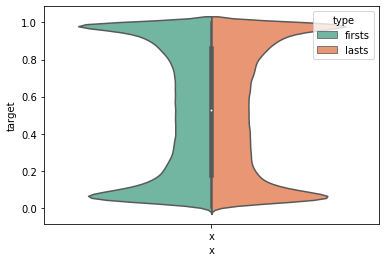

beta
Ks_2sampResult(statistic=0.026361151150111728, pvalue=0.0)


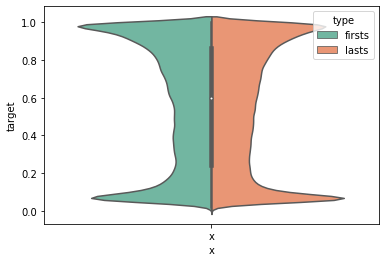

gamma
Ks_2sampResult(statistic=0.03337930891640162, pvalue=0.0)


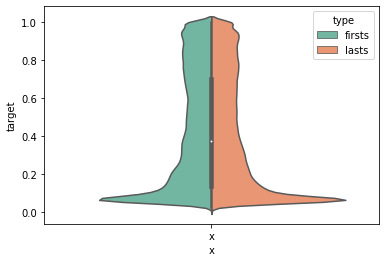

high_gamma
Ks_2sampResult(statistic=0.054015178210571474, pvalue=0.0)


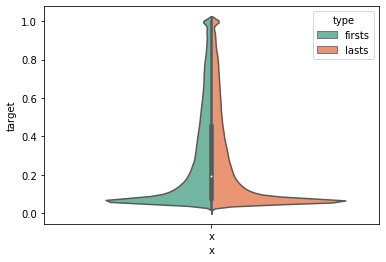

In [10]:
# compare first to last block
# compares individual data points
for band in block_base_data.keys():
    print(band)
    firsts = np.concatenate([block for block in block_base_first_data[band]], axis=None)
    lasts = np.concatenate([block for block in block_base_last_data[band]], axis=None)
    
    d = pd.DataFrame({"x": "x", "type": "firsts", "target": firsts}).append(pd.DataFrame({"x": "x", "type": 'lasts', "target": lasts}))
    sns.violinplot(x = "x", y = "target", hue="type", data=d, split=True, palette="Set2")
    
    print(ks_2samp(firsts, lasts))
    plt.show()


# Stats

In [10]:
trends_df = pd.DataFrame(columns= ["Band", "Val", "Type", "Metric"])

# compare not stim to stim
for band in block_base_data.keys():
    print(band)
    # check change in distribution
    bases = np.concatenate([block.mean(0) for block in block_base_data[band]], axis=None)
    stims = np.concatenate([block.mean(0) for block in block_stim_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":bases, "Type":"bases", "Metric":"avg"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stims, "Type":"stims", "Metric":"avg"}))
    print(stims.mean() - bases.mean())
    print(ttest_rel(bases, stims))
    
#    # check increase in mean
#    base_avgs = np.concatenate([block.mean() for block in block_base_data[band]], axis=None)
#    stim_avgs = np.concatenate([block.mean() for block in block_stim_data[band]], axis=None)
#    print(ttest_rel(base_avgs, stim_avgs))
    
    # check increase in variance over an electrode's connectivity to others
    base_elec_vars = np.concatenate([block.var(1).mean(0) for block in block_base_data[band]], axis=None)
    stim_elec_vars = np.concatenate([block.var(1).mean(0) for block in block_stim_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_elec_vars, "Type":"bases", "Metric":"var_elec"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_elec_vars, "Type":"stims", "Metric":"var_elec"}))
    print(stim_elec_vars.mean() - base_elec_vars.mean())
    print(ttest_rel(base_elec_vars, stim_elec_vars))
    
    # check increase in variance over entire space
    base_elec_vars = np.concatenate([np.reshape(block, [block.shape[0], block.shape[1]*block.shape[2]]).var(1).mean() for block in block_base_data[band]], axis=None)
    stim_elec_vars = np.concatenate([np.reshape(block, [block.shape[0], block.shape[1]*block.shape[2]]).var(1).mean() for block in block_stim_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_elec_vars, "Type":"bases", "Metric":"var_space"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_elec_vars, "Type":"stims", "Metric":"var_space"}))
    print(stim_elec_vars.mean() - base_elec_vars.mean())
    print(ttest_rel(base_elec_vars, stim_elec_vars))
    
    # check increase in variance over time
    base_time_vars = np.concatenate([block.var(0) for block in block_base_data[band]], axis=None)
    stim_time_vars = np.concatenate([block.var(0) for block in block_stim_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_time_vars, "Type":"bases", "Metric":"var_time"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_time_vars, "Type":"stims", "Metric":"var_time"}))
    print(stim_time_vars.mean() - base_time_vars.mean())
    print(ttest_rel(base_time_vars, stim_time_vars))
    
    # check increase in average squared correlations?

    # check increase in average squared correlation
    #base_covs = np.concatenate(get_cor(block_base_data[band]))
    #stim_covs = np.concatenate(get_cor(block_stim_data[band]))
    #print(np.mean(stim_covs) - np.mean(base_covs))
    #print(ttest_rel(base_covs, stim_covs))

    # check increase in clustering coeff (first without null)
    base_cc = np.concatenate(get_cc(block_base_data[band]), axis=None)
    stim_cc = np.concatenate(get_cc(block_stim_data[band]), axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_cc, "Type":"bases", "Metric":"cluster_coef"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_cc, "Type":"stims", "Metric":"cluster_coef"}))
    print(ttest_rel(base_cc, stim_cc))

    print()

theta
0.009557528756841238
Ttest_relResult(statistic=-122.33815144723779, pvalue=0.0)
-0.0011615088897973525
Ttest_relResult(statistic=15.215630686620257, pvalue=6.526077087684592e-52)
-0.0008302169147957339
Ttest_relResult(statistic=1.3863280708727834, pvalue=0.1671600428190949)
0.0012867446620917818
Ttest_relResult(statistic=-84.33944144069591, pvalue=0.0)


KeyboardInterrupt: 

In [11]:

# compare first base to last base
for band in block_base_data.keys():
    print(band)
    # check change in distribution
    bases = np.concatenate([block.mean(0) for block in block_base_first_data[band]], axis=None)
    stims = np.concatenate([block.mean(0) for block in block_base_last_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":bases, "Type":"first_base", "Metric":"avg"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stims, "Type":"last_base", "Metric":"avg"}))
    print(stims.mean() - bases.mean())
    print(ttest_rel(bases, stims))
    
    # check increase in mean
    base_avgs = np.concatenate([block.mean() for block in block_base_data[band]], axis=None)
    stim_avgs = np.concatenate([block.mean() for block in block_stim_data[band]], axis=None)
    print(ttest_rel(base_avgs, stim_avgs))
    
    # check increase in variance over an electrode's connectivity to others
    base_elec_vars = np.concatenate([block.var(1).mean(0) for block in block_base_first_data[band]], axis=None)
    stim_elec_vars = np.concatenate([block.var(1).mean(0) for block in block_base_last_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_elec_vars, "Type":"first_base", "Metric":"var_elec"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_elec_vars, "Type":"last_base", "Metric":"var_elec"}))
    print(stim_elec_vars.mean() - base_elec_vars.mean())
    print(ttest_rel(base_elec_vars, stim_elec_vars))
    
    # check increase in variance over entire space
    base_elec_vars = np.concatenate([np.reshape(block, [block.shape[0], block.shape[1]*block.shape[2]]).var(1).mean() for block in block_base_first_data[band]], axis=None)
    stim_elec_vars = np.concatenate([np.reshape(block, [block.shape[0], block.shape[1]*block.shape[2]]).var(1).mean() for block in block_base_last_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_elec_vars, "Type":"first_base", "Metric":"var_space"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_elec_vars, "Type":"last_base", "Metric":"var_space"}))
    print(stim_elec_vars.mean() - base_elec_vars.mean())
    print(ttest_rel(base_elec_vars, stim_elec_vars))
    
    # check increase in variance over time
    base_time_vars = np.concatenate([block.var(0) for block in block_base_first_data[band]], axis=None)
    stim_time_vars = np.concatenate([block.var(0) for block in block_base_last_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_time_vars, "Type":"first_base", "Metric":"var_time"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_time_vars, "Type":"last_base", "Metric":"var_time"}))
    print(stim_time_vars.mean() - base_time_vars.mean())
    print(ttest_rel(base_time_vars, stim_time_vars))
    
    # check increase in average squared correlations?

    # check increase in average covariance
    #base_covs = np.concatenate(get_cor(block_base_first_data[band]))
    #stim_covs = np.concatenate(get_cor(block_base_last_data[band]))
    #print(np.mean(stim_covs) - np.mean(base_covs))
    #print(ttest_rel(base_covs, stim_covs))

#     # check increase in clustering coeff (first without null)
#     base_cc = np.concatenate(get_cc(block_base_first_data[band]), axis=None)
#     stim_cc = np.concatenate(get_cc(block_base_last_data[band]), axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_cc, "Type":"first_base", "Metric":"cluster_coef"}))
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_cc, "Type":"last_base", "Metric":"cluster_coef"}))
#     print(ttest_rel(base_cc, stim_cc))

    print()

theta
0.0205243006889112
Ttest_relResult(statistic=-51.58013833458293, pvalue=0.0)
Ttest_relResult(statistic=-1.496649724555442, pvalue=0.13602996096176395)
0.001839350733966079
Ttest_relResult(statistic=-5.357974358563711, pvalue=9.023013549861739e-08)
0.0038684839997767603
Ttest_relResult(statistic=-1.277605609382413, pvalue=0.20875403692192257)
0.0021051966265743637
Ttest_relResult(statistic=-64.11185512369781, pvalue=0.0)

beta
-0.014167617520367437
Ttest_relResult(statistic=48.81599489357857, pvalue=0.0)
Ttest_relResult(statistic=-1.868661566012363, pvalue=0.06310334280997724)
0.0032115064536764187
Ttest_relResult(statistic=-11.321582194054647, pvalue=3.7358566466195665e-29)
0.004354581142916376
Ttest_relResult(statistic=-1.6969191002941022, pvalue=0.09748148987980434)
0.0005688722159416385
Ttest_relResult(statistic=-36.13117678207252, pvalue=4.026159443761694e-285)

gamma
-0.023123633672350152
Ttest_relResult(statistic=92.1614912988462, pvalue=0.0)
Ttest_relResult(statistic=0.121

# Plot

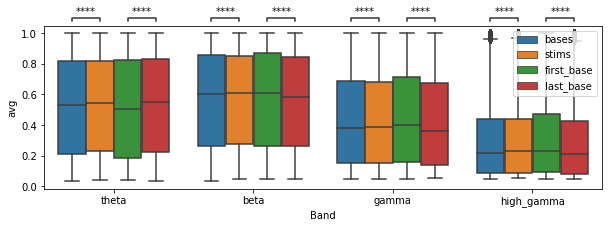

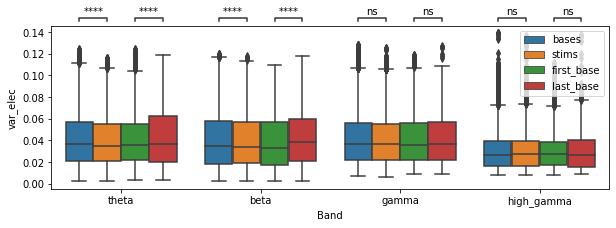

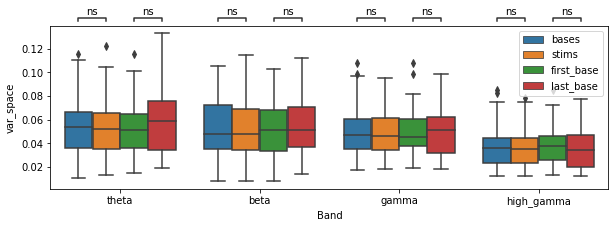

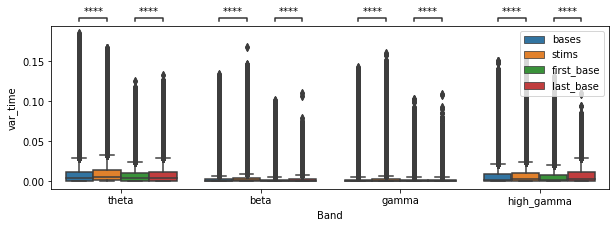

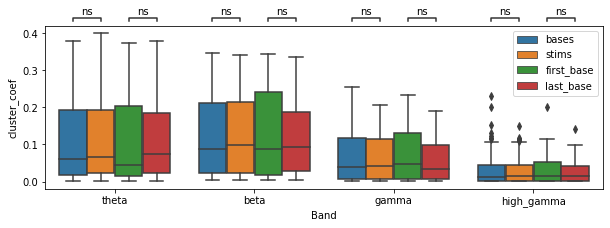

In [10]:
for metric in trends_df["Metric"].unique():
    d = trends_df[trends_df["Metric"]==metric]
    plt.figure(figsize=(10, 3))
    ax = sns.boxplot(x="Band", hue="Type", y="Val", data=d)
    ax.legend(loc="upper right")
    add_stat_annotation(ax, data=d, x="Band", hue="Type", y="Val", \
            box_pairs=[(("theta", "bases"), ("theta", "stims")), (("theta", "first_base"), ("theta", "last_base")),
                      (("beta", "bases"), ("beta", "stims")), (("beta", "first_base"), ("beta", "last_base")),
                      (("gamma", "bases"), ("gamma", "stims")), (("gamma", "first_base"), ("gamma", "last_base")),
                      (("high_gamma", "bases"), ("high_gamma", "stims")), (("high_gamma", "first_base"), ("high_gamma", "last_base"))],
                       test="t-test_paired", loc="outside", comparisons_correction=None, verbose=0)
    ax.set(ylabel=metric)
#     plt.savefig(metric+".png", dpi=300)
    #plt.show()

## KS Test

In [64]:
# trends_df = pd.DataFrame(columns= ["Band", "Val", "Type", "Metric"])

# # compare not stim to stim
# for band in block_base_data.keys():
#     print(band)
#     # check change in distribution
#     bases = np.concatenate([block.mean(0) for block in block_base_data[band]], axis=None)
#     stims = np.concatenate([block.mean(0) for block in block_stim_data[band]], axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":bases, "Type":"bases", "Metric":"avg"}))
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stims, "Type":"stims", "Metric":"avg"}))
#     print(stims.mean() - bases.mean())
#     print(ks_2samp(bases, stims))
    
# #    # check increase in mean
# #    base_avgs = np.concatenate([block.mean() for block in block_base_data[band]], axis=None)
# #    stim_avgs = np.concatenate([block.mean() for block in block_stim_data[band]], axis=None)
# #    print(ttest_rel(base_avgs, stim_avgs))
    
#     # check increase in variance over an electrode's connectivity to others
#     base_elec_vars = np.concatenate([block.var(1).mean(0) for block in block_base_data[band]], axis=None)
#     stim_elec_vars = np.concatenate([block.var(1).mean(0) for block in block_stim_data[band]], axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_elec_vars, "Type":"bases", "Metric":"var_elec"}))
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_elec_vars, "Type":"stims", "Metric":"var_elec"}))
#     print(stim_elec_vars.mean() - base_elec_vars.mean())
#     print(ks_2samp(base_elec_vars, stim_elec_vars))
    
#     # check increase in variance over entire space
#     base_elec_vars = np.concatenate([np.reshape(block, [block.shape[0], block.shape[1]*block.shape[2]]).var(1).mean() for block in block_base_data[band]], axis=None)
#     stim_elec_vars = np.concatenate([np.reshape(block, [block.shape[0], block.shape[1]*block.shape[2]]).var(1).mean() for block in block_stim_data[band]], axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_elec_vars, "Type":"bases", "Metric":"var_space"}))
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_elec_vars, "Type":"stims", "Metric":"var_space"}))
#     print(stim_elec_vars.mean() - base_elec_vars.mean())
#     print(ks_2samp(base_elec_vars, stim_elec_vars))
    
#     # check increase in variance over time
#     base_time_vars = np.concatenate([block.var(0) for block in block_base_data[band]], axis=None)
#     stim_time_vars = np.concatenate([block.var(0) for block in block_stim_data[band]], axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_time_vars, "Type":"bases", "Metric":"var_time"}))
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_time_vars, "Type":"stims", "Metric":"var_time"}))
#     print(stim_time_vars.mean() - base_time_vars.mean())
#     print(ks_2samp(base_time_vars, stim_time_vars))
    
#     # check increase in average squared correlations?

#     # check increase in average squared correlation
#     #base_covs = np.concatenate(get_cor(block_base_data[band]))
#     #stim_covs = np.concatenate(get_cor(block_stim_data[band]))
#     #print(np.mean(stim_covs) - np.mean(base_covs))
#     #print(ttest_rel(base_covs, stim_covs))

# #     # check increase in clustering coeff (first without null)
# #     base_cc = np.concatenate(get_cc(block_base_data[band]), axis=None)
# #     stim_cc = np.concatenate(get_cc(block_stim_data[band]), axis=None)
# #     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_cc, "Type":"bases", "Metric":"cluster_coef"}))
# #     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_cc, "Type":"stims", "Metric":"cluster_coef"}))
# #     print(ks_2samp(base_cc, stim_cc))

#     print()

theta
0.009557528756841238
Ks_2sampResult(statistic=0.01962980146223625, pvalue=1.2437160753738902e-209)
-0.0011615088897973525
Ks_2sampResult(statistic=0.023664122137404597, pvalue=0.00030054704678650774)
-0.0008302169147957339
Ks_2sampResult(statistic=0.04390243902439024, pvalue=0.9893927612484311)
0.0012867446620917818
Ks_2sampResult(statistic=0.042868798694546184, pvalue=0.0)

beta
0.005330250397549863
Ks_2sampResult(statistic=0.013412897755451403, pvalue=4.2165477754693747e-98)
-0.0006615237862419021
Ks_2sampResult(statistic=0.014312977099236734, pvalue=0.07987148503899587)
-0.00047005417369705427
Ks_2sampResult(statistic=0.05853658536585366, pvalue=0.8750668864615805)
0.0006046111881327179
Ks_2sampResult(statistic=0.0505815348680948, pvalue=0.0)

gamma
0.0004546266381617037
Ks_2sampResult(statistic=0.0081638856448078, pvalue=1.304204970915643e-36)
4.6530841468869766e-05
Ks_2sampResult(statistic=0.00992366412213741, pvalue=0.4212186429892839)
-0.00012237061483829498
Ks_2sampResult

In [69]:

# compare first base to first stim
for band in block_base_data.keys():
    print(band)
    
    # check change in distribution
    bases = np.concatenate([block.mean(0) for block in block_base_first_data[band]], axis=None)
    stims = np.concatenate([block.mean(0) for block in block_stim_first_data[band]], axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":bases, "Type":"first_base", "Metric":"avg"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stims, "Type":"first_stim", "Metric":"avg"}))
    print(stims.mean() - bases.mean())
    print(ks_2samp(bases, stims))
    
#     # check increase in mean
#     base_avgs = np.concatenate([block.mean() for block in block_base_first_data[band]], axis=None)
#     stim_avgs = np.concatenate([block.mean() for block in block_base_last_data[band]], axis=None)
#     print(ks_2samp(base_avgs, stim_avgs))
    
    # check increase in variance over an electrode's connectivity to others
    base_elec_vars = np.concatenate([block.var(1).mean(0) for block in block_base_first_data[band]], axis=None)
    stim_elec_vars = np.concatenate([block.var(1).mean(0) for block in block_base_last_data[band]], axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_elec_vars, "Type":"first_base", "Metric":"var_elec"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_elec_vars, "Type":"first_stim", "Metric":"var_elec"}))
    print(stim_elec_vars.mean() - base_elec_vars.mean())
    print(ks_2samp(base_elec_vars, stim_elec_vars))
    
    # check increase in variance over entire space
    base_elec_vars = np.concatenate([np.reshape(block, [block.shape[0], block.shape[1]*block.shape[2]]).var(1).mean() for block in block_base_first_data[band]], axis=None)
    stim_elec_vars = np.concatenate([np.reshape(block, [block.shape[0], block.shape[1]*block.shape[2]]).var(1).mean() for block in block_stim_first_data[band]], axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_elec_vars, "Type":"first_base", "Metric":"var_space"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_elec_vars, "Type":"first_stim", "Metric":"var_space"}))
    print(stim_elec_vars.mean() - base_elec_vars.mean())
    print(ks_2samp(base_elec_vars, stim_elec_vars))
    
    # check increase in variance over time
    base_time_vars = np.concatenate([block.var(0) for block in block_base_first_data[band]], axis=None)
    stim_time_vars = np.concatenate([block.var(0) for block in block_stim_first_data[band]], axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_time_vars, "Type":"first_base", "Metric":"var_time"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_time_vars, "Type":"first_stim", "Metric":"var_time"}))
    print(stim_time_vars.mean() - base_time_vars.mean())
    print(ks_2samp(base_time_vars, stim_time_vars))
    
    # check increase in average squared correlations?

    # check increase in average covariance
    #base_covs = np.concatenate(get_cor(block_base_first_data[band]))
    #stim_covs = np.concatenate(get_cor(block_base_last_data[band]))
    #print(np.mean(stim_covs) - np.mean(base_covs))
    #print(ttest_rel(base_covs, stim_covs))

#     # check increase in clustering coeff (first without null)
#     base_cc = np.concatenate(get_cc(block_base_first_data[band]), axis=None)
#     stim_cc = np.concatenate(get_cc(block_base_last_data[band]), axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_cc, "Type":"first_base", "Metric":"cluster_coef"}))
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_cc, "Type":"last_base", "Metric":"cluster_coef"}))
#     print(ks_2samp(base_cc, stim_cc))

    print()

theta
0.01962521659441996
Ks_2sampResult(statistic=0.04641880109427743, pvalue=2.1413863384274182e-234)
0.001839350733966079
Ks_2sampResult(statistic=0.07029262086513995, pvalue=3.547459521424118e-07)
-0.001540407736544784
Ks_2sampResult(statistic=0.0975609756097561, pvalue=0.99137579104805)
0.005342572335161496
Ks_2sampResult(statistic=0.10780392596029253, pvalue=0.0)

beta
0.003741162916929941
Ks_2sampResult(statistic=0.022765450269569776, pvalue=1.0586234730148905e-56)
0.0032115064536764187
Ks_2sampResult(statistic=0.07856234096692112, pvalue=7.349257610609363e-09)
0.0006592011566759828
Ks_2sampResult(statistic=0.07317073170731707, pvalue=0.9999427584427157)
0.0020383529985772784
Ks_2sampResult(statistic=0.11137152638904446, pvalue=0.0)

gamma
-0.008255264580468935
Ks_2sampResult(statistic=0.02264546370806475, pvalue=4.1342125422746535e-56)
7.660658818817168e-05
Ks_2sampResult(statistic=0.02321882951653944, pvalue=0.36498164328336385)
0.0005617496579215439
Ks_2sampResult(statistic=0

In [65]:

# compare first base to last base
for band in block_base_data.keys():
    print(band)
    
    # check change in distribution
    bases = np.concatenate([block.mean(0) for block in block_base_first_data[band]], axis=None)
    stims = np.concatenate([block.mean(0) for block in block_base_last_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":bases, "Type":"first_base", "Metric":"avg"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stims, "Type":"last_base", "Metric":"avg"}))
    print(stims.mean() - bases.mean())
    print(ks_2samp(bases, stims))
    
#     # check increase in mean
#     base_avgs = np.concatenate([block.mean() for block in block_base_first_data[band]], axis=None)
#     stim_avgs = np.concatenate([block.mean() for block in block_base_last_data[band]], axis=None)
#     print(ks_2samp(base_avgs, stim_avgs))
    
    # check increase in variance over an electrode's connectivity to others
    base_elec_vars = np.concatenate([block.var(1).mean(0) for block in block_base_first_data[band]], axis=None)
    stim_elec_vars = np.concatenate([block.var(1).mean(0) for block in block_base_last_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_elec_vars, "Type":"first_base", "Metric":"var_elec"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_elec_vars, "Type":"last_base", "Metric":"var_elec"}))
    print(stim_elec_vars.mean() - base_elec_vars.mean())
    print(ks_2samp(base_elec_vars, stim_elec_vars))
    
    # check increase in variance over entire space
    base_elec_vars = np.concatenate([np.reshape(block, [block.shape[0], block.shape[1]*block.shape[2]]).var(1).mean() for block in block_base_first_data[band]], axis=None)
    stim_elec_vars = np.concatenate([np.reshape(block, [block.shape[0], block.shape[1]*block.shape[2]]).var(1).mean() for block in block_base_last_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_elec_vars, "Type":"first_base", "Metric":"var_space"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_elec_vars, "Type":"last_base", "Metric":"var_space"}))
    print(stim_elec_vars.mean() - base_elec_vars.mean())
    print(ks_2samp(base_elec_vars, stim_elec_vars))
    
    # check increase in variance over time
    base_time_vars = np.concatenate([block.var(0) for block in block_base_first_data[band]], axis=None)
    stim_time_vars = np.concatenate([block.var(0) for block in block_base_last_data[band]], axis=None)
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_time_vars, "Type":"first_base", "Metric":"var_time"}))
    trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_time_vars, "Type":"last_base", "Metric":"var_time"}))
    print(stim_time_vars.mean() - base_time_vars.mean())
    print(ks_2samp(base_time_vars, stim_time_vars))
    
    # check increase in average squared correlations?

    # check increase in average covariance
    #base_covs = np.concatenate(get_cor(block_base_first_data[band]))
    #stim_covs = np.concatenate(get_cor(block_base_last_data[band]))
    #print(np.mean(stim_covs) - np.mean(base_covs))
    #print(ttest_rel(base_covs, stim_covs))

#     # check increase in clustering coeff (first without null)
#     base_cc = np.concatenate(get_cc(block_base_first_data[band]), axis=None)
#     stim_cc = np.concatenate(get_cc(block_base_last_data[band]), axis=None)
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":base_cc, "Type":"first_base", "Metric":"cluster_coef"}))
#     trends_df = trends_df.append(pd.DataFrame({"Band":band, "Val":stim_cc, "Type":"last_base", "Metric":"cluster_coef"}))
#     print(ks_2samp(base_cc, stim_cc))

    print()

theta
0.0205243006889112
Ks_2sampResult(statistic=0.04275521141632138, pvalue=6.387676874684272e-199)
0.001839350733966079
Ks_2sampResult(statistic=0.07029262086513995, pvalue=3.547459521424118e-07)
0.0038684839997767603
Ks_2sampResult(statistic=0.1951219512195122, pvalue=0.42017824559389316)
0.0021051966265743637
Ks_2sampResult(statistic=0.05637768569920165, pvalue=0.0)

beta
-0.014167617520367437
Ks_2sampResult(statistic=0.03126849792823205, pvalue=1.3634936075274062e-106)
0.0032115064536764187
Ks_2sampResult(statistic=0.07856234096692112, pvalue=7.349257610609363e-09)
0.004354581142916376
Ks_2sampResult(statistic=0.17073170731707318, pvalue=0.5945211330032322)
0.0005688722159416385
Ks_2sampResult(statistic=0.07314380789351593, pvalue=0.0)

gamma
-0.023123633672350152
Ks_2sampResult(statistic=0.03269233845809272, pvalue=1.7609323470344798e-116)
7.660658818817168e-05
Ks_2sampResult(statistic=0.02321882951653944, pvalue=0.36498164328336385)
-0.0010717275309095053
Ks_2sampResult(statist

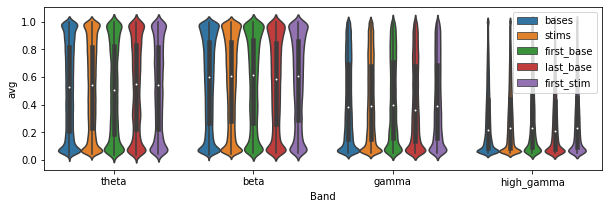

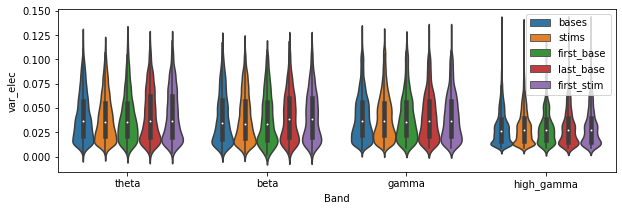

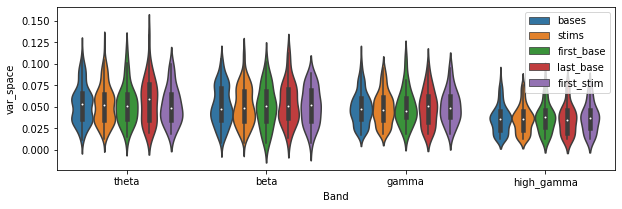

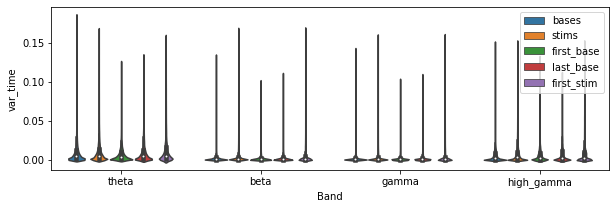

In [70]:
for metric in trends_df["Metric"].unique():
    d = trends_df[trends_df["Metric"]==metric]
    plt.figure(figsize=(10, 3))
    ax = sns.violinplot(x="Band", hue="Type", y="Val", data=d) #, split=True)
    ax.legend(loc="upper right")
    ax.set(ylabel=metric)
#     plt.savefig(metric+".png", dpi=300)
    plt.show()

In [58]:
# trends_df = trends_df[trends_df["Type"] != "bases"]
# trends_df = trends_df[trends_df["Type"] != "stims"]